In [1]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import time
import sys 
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, confusion_matrix
from tensorflow.keras.layers import AveragePooling2D
import cv2
import re
import pandas as pd
from utils import *
from scipy.linalg import hadamard

sys.path.append("./models/GPA")
from useful_functions import *
sys.path.append("./models/robust-pca-master/")
sys.path.append("./models/sssr/")
sys.path.append("./models/sssr/SLIC-master/python_interface/")

In [2]:
# my version of the B-SSSR algorithm of the paper ``Moving Object Detection in Complex Scene Using Spatiotemporal Structured-Sparse RPCA"
from sssr import SSSR

In [3]:
# superpixel codes are from
from SLICdemo import *

In [4]:
# local binary patterns (LBP) codes are from https://github.com/arsho/local_binary_patterns/blob/master/lbp.py
sys.path.append("./models/sssr/local_binary_patterns-master/")
from lbp import lbp_calculated_pixel

In [5]:
# nearest neighbor searching codes are from 
# One should run `pip install pyflann-py3` or `sh install.sh` to ensure the install of pyflann
import pyflann

# Load Dataset

In [6]:
dataset_name = "pedestrians"
result_path = f"./dataset/results/{dataset_name}"
img_path = f"./dataset/baseline/{dataset_name}/"
print(result_path, img_path)

./dataset/results/pedestrians ./dataset/baseline/pedestrians/


In [7]:
# Ground Truth Files
gt_files = glob.glob(img_path + "groundtruth/*png")
gt_files.sort()

# Raw Image Failes
raw_files = glob.glob(img_path + "input/*jpg")
raw_files.sort()

print(len(gt_files), len(raw_files))

1099 1099


In [8]:
# Example Ground Truth
i = 950
gt_img = Image.open(gt_files[i])
gt_img = np.array(gt_img).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0
gt_img.shape

(240, 360)

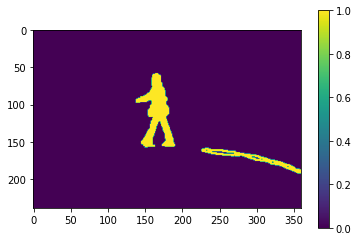

In [9]:
plt.imshow(gt_img)
plt.colorbar()

In [10]:
# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32)
# mean image
raw_img = np.mean(raw_img, axis=-1)

In [11]:
p, q = raw_img.shape[0:2]

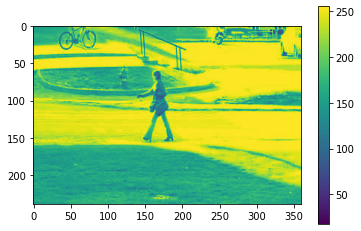

In [12]:
plt.imshow(raw_img)
plt.colorbar()

# SSSR

In [13]:
# Part IV. Experimental Evaluation
# p, q = 240, 360  #
s = 2500           # the number of superpixels
k = 100            # the number of frames
epsilon1 = 20      # the number of nearest neighbors

start_idx = 0

In [14]:
raw_batch = np.zeros((k, p, q))
gt_batch = np.zeros((k, p, q))
middle_name = raw_files[start_idx + k // 2]

for img_idx in range(k):
    # Example Raw Image
    raw_img = Image.open(raw_files[start_idx + img_idx])
    raw_img = np.array(raw_img) / 255.0  # with shape (p, q, 3)
    raw_img = raw_img.mean(axis=-1)
    raw_batch[img_idx] = raw_img
    
    # Ground Truth Image
    gt_img = Image.open(gt_files[start_idx + img_idx])
    gt_img = np.array(gt_img)  # with shape (p, q)
    gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
    gt_img = gt_img.astype(np.float64) / 255.0
    gt_batch[img_idx] = gt_img

In [15]:
t1 = time.time()
sssr_model = SSSR(X=raw_batch, middle_name=middle_name, s=s, epsilon1=epsilon1)
t2 = time.time()
print(f"Total time cost: {t2 - t1: .4f}")

Compiled library exists
3 channels
number of output superpixels:  2523
segmentation time taken in seconds:  0.19803059473633766
Total time cost:  25.8401


In [16]:
t1 = time.time()
B, F = sssr_model.fit(100)
t2 = time.time()
print(f"Total time cost: {t2 - t1: .4f}")

Iter 0: p1:402.1594; p2:4736.8023; p3:0.0010; p4:0.0010
Iter 1: p1:394.3220; p2:8622.8517; p3:-18.5413; p4:-19.3791
Iter 2: p1:387.7408; p2:11872.0648; p3:-49.1733; p4:-61.9208
Iter 3: p1:382.2498; p2:14573.4324; p3:-89.5560; p4:-127.4391
Iter 4: p1:377.7043; p2:16802.1891; p3:-135.2449; p4:-212.1814
Iter 5: p1:373.9774; p2:18622.8689; p3:-181.8486; p4:-309.9189
Iter 6: p1:370.9578; p2:20091.6700; p3:-225.5467; p4:-412.9868
Iter 7: p1:368.5475; p2:21257.8363; p3:-263.3387; p4:-513.2540
Iter 8: p1:366.6607; p2:22164.6966; p3:-293.1102; p4:-602.9869
Iter 9: p1:365.2221; p2:22849.8245; p3:-313.5924; p4:-675.5756
Iter 10: p1:364.1656; p2:23346.2331; p3:-324.2707; p4:-726.0851
Iter 11: p1:363.4338; p2:23682.3445; p3:-325.2743; p4:-751.5992
Iter 12: p1:362.9762; p2:23882.9711; p3:-317.2611; p4:-751.3423
Iter 13: p1:362.7492; p2:23969.9003; p3:-301.3052; p4:-726.5818
Iter 14: p1:362.7147; p2:23962.1022; p3:-278.7859; p4:-680.3341
Iter 15: p1:362.8394; p2:23876.0036; p3:-251.2785; p4:-616.9225

In [17]:
X_F = sssr_model.convert_back(F)

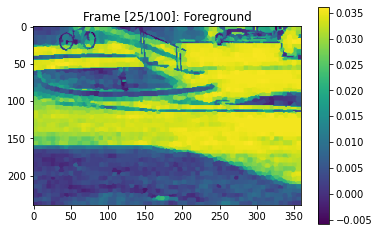

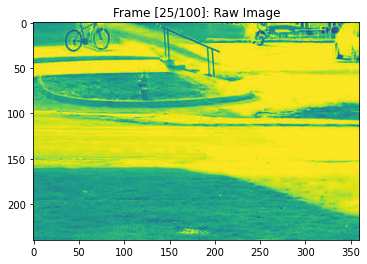

In [18]:
idx = int(k * 0.25)
plt.imshow(X_F[idx])
plt.title(f"Frame [{idx}/{k}]: Foreground")
plt.colorbar()
plt.show()
plt.imshow(raw_batch[idx])
plt.title(f"Frame [{idx}/{k}]: Raw Image")
plt.show()

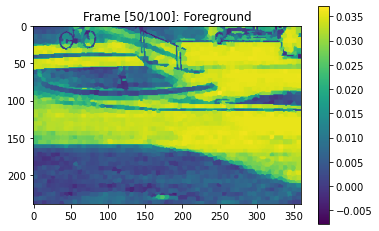

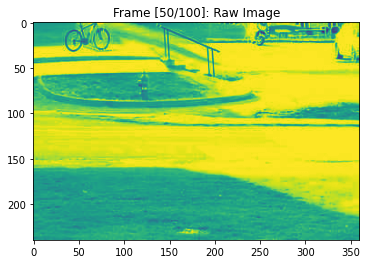

In [19]:
idx = int(k * 0.5)
plt.imshow(X_F[idx])
plt.colorbar()
plt.title(f"Frame [{idx}/{k}]: Foreground")
plt.show()
plt.imshow(raw_batch[idx])
plt.title(f"Frame [{idx}/{k}]: Raw Image")
plt.show()

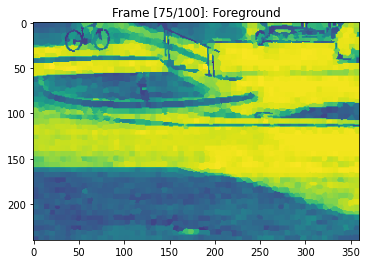

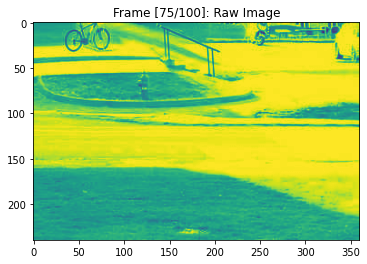

In [20]:
idx = int(k * 0.75)
plt.imshow(X_F[idx])
plt.title(f"Frame [{idx}/{k}]: Foreground")
plt.show()
plt.imshow(raw_batch[idx])
plt.title(f"Frame [{idx}/{k}]: Raw Image")
plt.show()

## Metrics Evaluation

In [21]:
idx = int(k * 0.5)

In [22]:
np.percentile(X_F, 1)

-0.0016328586177420024

In [23]:
sssr_thres = -0.025
mask = (X_F < sssr_thres) * 1.0

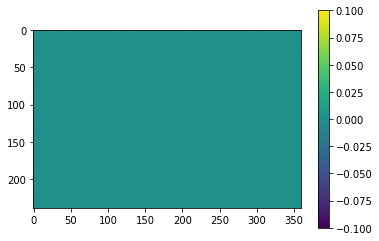

In [24]:
plt.imshow(mask[idx])
plt.colorbar()
plt.show()

In [25]:
frame_mask = mask[idx]
frame_gt = gt_batch[idx]
y_predict = frame_mask.ravel()
y_true = frame_gt.ravel()
f1 = f1_score(y_true, y_predict)  # F1-score
f1

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.0

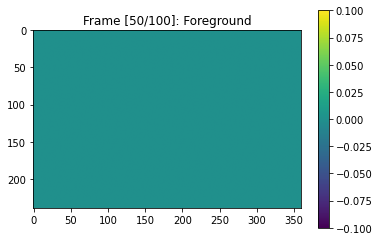

In [26]:
plt.imshow(frame_mask)
plt.colorbar()
plt.title(f"Frame [{idx}/{k}]: Foreground")
plt.show()

In [27]:
y_predict = mask.ravel()
y_true = gt_batch.ravel()

tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
print(tn, fp, fn, tp)

8639991 9 0 0


In [28]:
P = tp / (tp + fp)
R = tp / (tp + fn)
P, R

/tmp/ipykernel_104/3990188850.py:2: RuntimeWarning: invalid value encountered in long_scalars
  R = tp / (tp + fn)


(0.0, nan)

In [29]:
f1 = 2 * P * R / (P + R)                              # F1-score

In [30]:
print(f1, R)

nan nan


## Evaluate the whole video

In [32]:
s = 2500            # the number of superpixels
ww = 100            # window width, the number of frames
epsilon1 = 20       # the number of nearest neighbors

sssr_thres = -0.025

In [33]:
results_list = []

In [34]:
start_idx = 0
end_idx = start_idx + ww

In [35]:
while (start_idx < len(raw_files)):
    print(f"================================[Frame {start_idx}-{end_idx}]================================")
    # read window
    k = end_idx - start_idx  # this window's width, which may be smaller than ww in the last window
    raw_batch = np.zeros((k, p, q))
    gt_batch = np.zeros((k, p, q))
    for img_idx in range(k):
        # Raw Image Batch
        raw_img = Image.open(raw_files[start_idx + img_idx])
        raw_img = np.array(raw_img) / 255.0  # with shape (p, q, 3)
        raw_img = raw_img.mean(axis=-1)
        raw_batch[img_idx] = raw_img

        # Ground Truth Image Batch
        gt_img = Image.open(gt_files[start_idx + img_idx])
        gt_img = np.array(gt_img)  # with shape (p, q)
        gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
        gt_img = gt_img.astype(np.float64) / 255.0
        gt_batch[img_idx] = gt_img
    
    ###################### SSSR ######################
    t1 = time.time()
    # 1. build the SSSR model
    sssr_model = SSSR(X=raw_batch, middle_name=middle_name, s=s, epsilon1=epsilon1)
    print(f"- build the SSSR model time cost: {t2 - t1: .4f}")
    # 2. model fitting
    B, F = sssr_model.fit(100)
    X_F = sssr_model.convert_back(F)
    # 3. thresholding
    mask = (X_F < sssr_thres) * 1.0
    t2 = time.time()
    sssr_time = t2 - t1
    print(f"- fitting the SSST model time cost: {sssr_time: .4f}")
    
    # evaluate the metrics
    # middle frame
    y_predict = frame_mask.ravel()
    y_true = frame_gt.ravel()
    # whole window
    y_predict = mask.ravel()
    y_true = gt_batch.ravel()
    conf_mat = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
    if len(conf_mat) == 1:
        tn, fp, fn, tp = conf_mat[0], 0, 0, 0
    else:
        tn, fp, fn, tp = conf_mat
    
    # record the results
    results_list.append([k, sssr_time, tn, fp, fn, tp])
    results_df = pd.DataFrame(results_list, columns=["k", "sssr_time", "tn", "fp", "fn", "tp"])
    results_df.to_csv(f"./sssr-{dataset_name}.csv")
    
    # update window index
    start_idx = end_idx
    end_idx = min(end_idx + ww, len(raw_files))

================================[Frame 0-100]================================
Compiled library exists
3 channels
number of output superpixels:  2523
segmentation time taken in seconds:  0.16234307177364826
- build the SSSR model time cost: -164.4371
Iter 0: p1:402.1594; p2:4736.8023; p3:0.0010; p4:0.0010
Iter 1: p1:394.3220; p2:8622.8517; p3:-33.2938; p4:-24.6658
Iter 2: p1:387.7408; p2:11872.0648; p3:-85.4984; p4:-78.9546
Iter 3: p1:382.2498; p2:14573.4324; p3:-156.7736; p4:-162.7734
Iter 4: p1:377.7043; p2:16802.1891; p3:-239.9186; p4:-271.4515
Iter 5: p1:373.9774; p2:18622.8689; p3:-327.6417; p4:-397.0878
Iter 6: p1:370.9578; p2:20091.6700; p3:-412.9320; p4:-529.8443
Iter 7: p1:368.5475; p2:21257.8363; p3:-489.3851; p4:-659.1675
Iter 8: p1:366.6607; p2:22164.6966; p3:-551.5754; p4:-774.8986
Iter 9: p1:365.2221; p2:22849.8245; p3:-595.4285; p4:-868.2328
Iter 10: p1:364.1656; p2:23346.2331; p3:-618.5294; p4:-932.4786
Iter 11: p1:363.4338; p2:23682.3445; p3:-620.2855; p4:-963.5708
Iter

In [36]:
results_df

,k,sssr_time,tn,fp,fn,tp
0,100,287.967738,8639991,9,0,0
1,100,276.710398,8640000,0,0,0
2,100,252.653546,8640000,0,0,0
3,100,161.159703,8511476,28555,47086,52883
4,100,157.009621,8469010,34834,60030,76126
5,100,162.415570,8499063,35975,26941,78021
6,100,150.258264,8474673,47681,11495,106151
7,100,233.729337,8637014,979,83,1924
8,100,187.100401,8559679,16128,16247,47946
9,100,170.378879,8512531,28246,19553,79670


In [38]:
total_fp = results_df.fp.sum()
total_fn = results_df.fn.sum()
total_tp = results_df.tp.sum()

In [41]:
f1, Recall, Precision = compute_metrics(total_fp, total_fn, total_tp)
f1, Recall, Precision

(0.7104979391697223, 0.7214017189824434, 0.6999188665028571)

In [43]:
total_time = results_df.sssr_time.sum()
n = results_df.k.sum()

In [44]:
avg_time = total_time / n
avg_time

2.017768060000405